In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from joblib import dump
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import uniform, randint

In [6]:
# Load training data
train_data = pd.read_csv('H9/DMR_method_input_NAs.csv')
# Load test data (holdout set)
test_data = pd.read_csv('H9/DMR_method_holdout_NAs.csv')

In [7]:
# Specify the features to use
features_to_use = ['H3K18ac_1', 'H3K14ac_1', 'H2AFZ_1', 'H3K4me1_1', 'H3K4me2_1', 'H3K4me3_1', 'ATAC_signalValues']

In [8]:
# Separate features and the target variable
X_train = train_data.drop('STARR_seq_binary', axis=1)
y_train = train_data['STARR_seq_binary']
X_test = test_data.drop('STARR_seq_binary', axis=1)
y_test = test_data['STARR_seq_binary']

In [9]:
# Drop the specified columns
columns_to_drop = ['seqnames', 'start', 'end', 'width', 'strand']
X_train_dropped = X_train.drop(columns=columns_to_drop)
X_test_dropped = X_test.drop(columns=columns_to_drop)

In [10]:
# Fill NaN values with zero in the datasets
X_train_filled = X_train_dropped.fillna(0)
X_test_filled = X_test_dropped.fillna(0)

In [11]:
# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filled, y_train)

In [12]:
# Define the parameter grid for RandomizedSearchCV with adjusted ranges
param_dist = {
    'n_estimators': randint(50, 300),  # Adjusted range
    'max_depth': randint(3, 10),  # Adjusted range
    'learning_rate': uniform(0.01, 0.2),  # Adjusted range
    'subsample': uniform(0.6, 0.4),  # Ensures values between 0.6 and 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # Ensures values between 0.6 and 1.0
    'reg_alpha': uniform(0.0, 1.0),  # Adjusted range
    'reg_lambda': uniform(0.0, 1.0)  # Adjusted range
}

In [13]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

In [14]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, cv=3, n_jobs=-1, verbose=10, scoring='roc_auc')

In [15]:
# Fit RandomizedSearchCV to the training data
random_search.fit(X_train_balanced, y_train_balanced)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [24]:
# Best model from RandomizedSearchCV
best_xgb_model = random_search.best_estimator_
print(f"Best parameters found: {random_search.best_params_}")

Best parameters found: {'colsample_bytree': 0.7409088881406595, 'learning_rate': 0.15913020037294529, 'max_depth': 9, 'n_estimators': 284, 'reg_alpha': 0.8634000300949498, 'reg_lambda': 0.7341591725060639, 'subsample': 0.838325586654235}


In [25]:
# Save the best model
dump(best_xgb_model, 'xgboost_model_balanced_smote_best_7.joblib')
print("Best XGBoost model saved successfully!")

Best XGBoost model saved successfully!


In [26]:
def save_roc_curve_data_with_predictions(model, X, y, original_data, filename, threshold_range=np.linspace(0.5, 1.0, num=500)):
    """
    Computes and saves the ROC curve data and predictions for a given model and dataset with specified threshold range.

    Parameters:
    - model: Trained model to be evaluated.
    - X: Feature matrix.
    - y: True labels.
    - original_data: Original dataframe containing 'chr', 'start', and 'end' columns.
    - filename: Base filename for saving the outputs.
    - threshold_range: Range of threshold values to consider for generating the ROC curve.

    Outputs:
    - Saves ROC curve data to a CSV file.
    - Saves prediction data to a CSV file.
    """

    # Predict probabilities for the positive class
    y_prob = model.predict_proba(X)[:, 1]

    # Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(y, y_prob)

    # Compute the Area Under the ROC Curve (AUC)
    roc_auc = roc_auc_score(y, y_prob)

    # Create a DataFrame to save the ROC curve data
    roc_data = pd.DataFrame({
        'False Positive Rate': fpr,
        'True Positive Rate': tpr,
        'Thresholds': thresholds
    })

    # Create a DataFrame to save the predictions
    pred_data = original_data[['chr', 'start', 'end']].copy()
    pred_data['Actual'] = y
    pred_data['Probabilities'] = y_prob

    # Ensure pred_data only contains the specified columns
    pred_data = pred_data[['chr', 'start', 'end', 'Actual', 'Probabilities']]

    # Save the ROC curve data
    roc_data.to_csv(filename.replace('.csv', '_roc.csv'), index=False)
    print(f"ROC AUC: {roc_auc:.2f} saved to {filename.replace('.csv', '_roc.csv')}")

    # Save the prediction data
    pred_data.to_csv(filename.replace('.csv', '_predictions.csv'), index=False)
    print(f"Predictions saved to {filename.replace('.csv', '_predictions.csv')}")

    return thresholds

In [27]:
# Compute and save ROC curve data for the best XGBoost model on test data with continuous higher threshold values
save_roc_curve_data_with_predictions(best_xgb_model, X_test_filled, y_test, 'roc_curve_xgboost_test_7.csv', threshold_range=np.linspace(0.5, 1.0, num=500))

C:\Users\roxan\AppData\Local\Temp\ipykernel_20252\2689218062.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred_data[pred_col_name] = (y_prob >= threshold).astype(int)
C:\Users\roxan\AppData\Local\Temp\ipykernel_20252\2689218062.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pred_data[pred_col_name] = (y_prob >= threshold).astype(int)
C:\Users\roxan\AppData\Local\Temp\ipykernel_20252\2689218062.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

ROC AUC: 0.77 saved to roc_curve_xgboost_test_7_roc.csv
Predictions saved to roc_curve_xgboost_test_7_predictions.csv


array([          inf, 9.9957210e-01, 9.9747062e-01, ..., 1.6379985e-06,
       1.6374300e-06, 2.2542219e-08], dtype=float32)

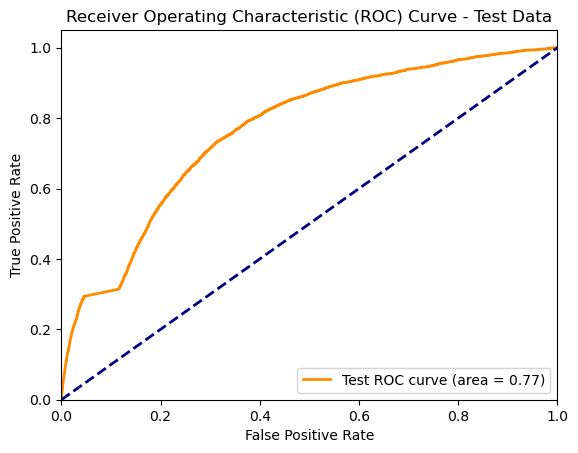

In [28]:
# Plot the ROC curve for the test data
y_prob_test = best_xgb_model.predict_proba(X_test_filled)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_prob_test)
roc_auc_test = roc_auc_score(y_test, y_prob_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc='lower right')
plt.show()

In [29]:
# Find the optimal threshold using Youden's J statistic
youden_index = tpr_test - fpr_test
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds_test[optimal_idx]
print(f'Optimal Threshold: {optimal_threshold:.2f}')

Optimal Threshold: 0.01


In [30]:
# Apply the optimal threshold to make new class predictions
y_pred_optimal = (y_prob_test >= optimal_threshold).astype(int)

In [31]:
# Evaluate the model on the holdout (test) data with the optimal threshold
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print(f'Accuracy of the XGBoost model on holdout data with optimal threshold: {accuracy_optimal}')

Accuracy of the XGBoost model on holdout data with optimal threshold: 0.6881552473790105


In [32]:
# Generate and print the classification report on the holdout (test) data with the optimal threshold
report_optimal = classification_report(y_test, y_pred_optimal, target_names=['0', '1'], digits=2)
print("Classification Report on holdout data with optimal threshold:")
print(report_optimal)

Classification Report on holdout data with optimal threshold:
              precision    recall  f1-score   support

           0       1.00      0.69      0.81    496189
           1       0.02      0.73      0.03      3813

    accuracy                           0.69    500002
   macro avg       0.51      0.71      0.42    500002
weighted avg       0.99      0.69      0.81    500002

